# Train a ML Model Based Solely on the Survey Dataframe

Because the model trained on linguistic features performs bad, we decided to train another model only on the survey dataframe and then extract important features to improve the original model. 

## 1. Import Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

## 2. Preprocessing Data


### 2.1. Clean Data

The datatype of "Level" column is not consistent so we convert them to integers and filter out the "Archive" and nan values.

In [4]:
survey_df = pd.read_csv('EndOfCourseSurvey.csv')

/Users/qichao/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
survey_df['Level'].unique()

array([3, 4, 5, 1, 2, '2', '1', '4', '3', 'Archive', nan, '5'],
      dtype=object)

In [6]:
survey_df = survey_df[survey_df['Level'] != 'Archive'].dropna()
survey_df['Level'] = survey_df['Level'].apply(np.int64)
survey_df['Level'].unique()

array([3, 4, 5, 1, 2])

In [7]:
survey_df = survey_df[survey_df['Response_Q2'] != 'Did Not Respond'].dropna()
survey_df["Response_Q2"].unique()

array(['Agree', 'Strongly Agree', 'Neutral', 'Disagree',
       'Strongly Disagree'], dtype=object)

In [8]:
survey_df = survey_df[survey_df['Response_Q3'] != 'Did Not Respond'].dropna()
survey_df["Response_Q3"].unique()

array(['Agree', 'Strongly Agree', 'Neutral', 'Disagree',
       'Strongly Disagree'], dtype=object)

In [9]:
survey_df = survey_df[survey_df['Response_Q4'] != 'Did Not Respond'].dropna()
survey_df["Response_Q4"].unique()

array(['Agree', 'Strongly Agree', 'Neutral', 'Disagree',
       'Strongly Disagree'], dtype=object)

In [10]:
survey_df["CustomerID"].unique()

array([198151, 152550, 191851, ..., 173145, 238281, 202949])

In [11]:
survey_df["Price"].unique()

array([197., 147.,  97.,   0.,  99.])

In [12]:
survey_df["Program"].unique()

array(['FMVA', 'CBCA', 'BIDA', 'CMSA', 'CRE', 'ESG', 'BIDA, FMVA',
       'Cryptocurrency', 'FPWMA', 'ML', 'ALL PROGRAMS'], dtype=object)

In [13]:
survey_df["Requirement"].unique()

array(['Core', 'Elective', 'Prep', 'Case Study'], dtype=object)

In [14]:
survey_df = survey_df[survey_df['VideoLenght'] != 'Archive'].dropna()
survey_df['VideoLenght'].unique()

array(['2-3 hrs', 'Over 3 hrs', 'Under 1 hr', '1-2 hrs'], dtype=object)

In [15]:
survey_df_clean = survey_df[["Response_Q1", "Response_Q2", "Response_Q3", "Response_Q4", "CustomerID", "Program", "Requirement", "Level", "VideoLenght", "Price"]]

In [18]:
survey_df_clean

,Response_Q1,Response_Q2,Response_Q3,Response_Q4,CustomerID,Program,Requirement,Level,VideoLenght,Price
0,9,Agree,Agree,Agree,198151,FMVA,Core,3,2-3 hrs,197.0
1,9,Agree,Agree,Agree,152550,FMVA,Core,3,2-3 hrs,197.0
2,10,Strongly Agree,Strongly Agree,Strongly Agree,191851,FMVA,Core,3,2-3 hrs,197.0
3,10,Strongly Agree,Strongly Agree,Strongly Agree,263617,FMVA,Core,3,2-3 hrs,197.0
4,10,Strongly Agree,Strongly Agree,Strongly Agree,305095,FMVA,Core,3,2-3 hrs,197.0
...,...,...,...,...,...,...,...,...,...,...
619116,10,Strongly Agree,Strongly Agree,Strongly Agree,245227,FMVA,Core,3,2-3 hrs,197.0
619118,10,Strongly Agree,Strongly Agree,Strongly Agree,134180,FMVA,Core,3,2-3 hrs,197.0
619119,8,Agree,Agree,Agree,171726,FMVA,Core,3,2-3 hrs,197.0
619120,10,Strongly Agree,Strongly Agree,Strongly Agree,192369,FMVA,Core,3,2-3 hrs,197.0


### 2.2. Train/Test Split 

In [125]:
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

train_df, test_df = train_test_split(survey_df_clean, test_size=0.10, random_state=123)
train_df.head()

,Response_Q1,Response_Q2,Response_Q3,Response_Q4,CustomerID,Program,Requirement,Level,VideoLenght,Price
222919,1,Strongly Disagree,Strongly Disagree,Strongly Disagree,268592,CMSA,Elective,4,Over 3 hrs,147.0
92686,8,Neutral,Agree,Agree,101246,FMVA,Prep,2,1-2 hrs,0.0
363329,10,Strongly Agree,Strongly Agree,Strongly Agree,122642,FMVA,Elective,2,2-3 hrs,97.0
401825,10,Strongly Agree,Strongly Agree,Strongly Agree,172724,FMVA,Prep,2,Under 1 hr,0.0
297372,8,Neutral,Agree,Agree,186949,ESG,Core,1,Under 1 hr,0.0


### 2.3. Let's separate `X` and `y`

In [126]:
train_df.shape

(545100, 10)

In [127]:
X_train = train_df.drop(columns=["Response_Q1"])
y_train = train_df["Response_Q1"]

X_test = test_df.drop(columns=["Response_Q1"])
y_test = test_df["Response_Q1"]

### 2.4. EDA

In [128]:
train_df.describe()

,Response_Q1,CustomerID,Level,Price
count,545100.000000,545100.000000,545100.000000,545100.000000
mean,8.904641,188468.585766,2.291411,64.497004
std,1.535084,68461.700074,0.818367,72.513035
min,1.000000,69810.000000,1.000000,0.000000
25%,8.000000,129349.000000,2.000000,0.000000
50%,10.000000,188690.000000,2.000000,0.000000
75%,10.000000,247709.000000,3.000000,97.000000
max,10.000000,307036.000000,5.000000,197.000000


In [130]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545100 entries, 222919 to 280955
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Response_Q1  545100 non-null  int64  
 1   Response_Q2  545100 non-null  object 
 2   Response_Q3  545100 non-null  object 
 3   Response_Q4  545100 non-null  object 
 4   CustomerID   545100 non-null  int64  
 5   Program      545100 non-null  object 
 6   Requirement  545100 non-null  object 
 7   Level        545100 non-null  int64  
 8   VideoLenght  545100 non-null  object 
 9   Price        545100 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 45.7+ MB


## 3. Build the pipeline

### 3.1. Feature Types

In [140]:
drop_features = ["CustomerID"]
#numeric_features = [
#    "Level",
#    "Price"
#]
ordinal_features_reg = [
    "Response_Q2",
    "Response_Q3",
    "Response_Q4"
]
ordering = [
    'Strongly Agree', 
    'Agree', 
    'Neutral', 
    'Disagree',
    'Strongly Disagree'
]

categorical_features = [
    "Program",
    "Requirement"
    
]

ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'],
 ['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'],
 ['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree']]

We'll pass the above as categories in our OrdinalEncoder

- There are a bunch more ordinal features using different scales.
  - These we'll be calling `ordinal_features_oth`. 
  - We are encoding them separately. 

In [135]:
ordinal_features_oth = [
    "Level",
    "VideoLenght",
    "Price"
]

ordering_ordinal_oth = [
    [1, 2, 3, 4, 5],
    ['Under 1 hr', '1-2 hrs', '2-3 hrs', 'Over 3 hrs'],
    [0., 97., 99., 147., 197.],
]

### 3.2. Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [141]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
# numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    #(numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

### 3.3. Examining the preprocessed data

In [142]:
preprocessor.fit(X_train)  # Calling fit to examine all the transformers.
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Strongly Agree', 'Agree',
                                              'Neutral', 'Disagree',
                                              'Strongly Disagree'],
                                             ['Strongly Agree', 'Agree',
                                              'Neutral', 'Disagree',
                                              'Strongly Disagree'],
                                             ['Strongly Agree', 'Agree',
                                              'Neutral', 'Disagree',
                                              'Strongly Disagree']]))]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[[1, 2, 3, 4, 5],
                                

In [146]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = (
    ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [1]:
new_columns

NameError: name 'new_columns' is not defined

In [148]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,Response_Q2,Response_Q3,Response_Q4,Level,VideoLenght,Price,Program_ALL PROGRAMS,Program_BIDA,"Program_BIDA, FMVA",Program_CBCA,...,Program_CRE,Program_Cryptocurrency,Program_ESG,Program_FMVA,Program_FPWMA,Program_ML,Requirement_Case Study,Requirement_Core,Requirement_Elective,Requirement_Prep
222919,4.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
92686,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
363329,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
401825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
297372,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [150]:
X_train_enc.shape

(545100, 21)

### 3.4. Model building 

#### 3.4.1. `DummyRegressor`

In [153]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.241748,0.007085,-1.030719e-05,0.0
1,0.086172,0.002292,-1.589615e-09,0.0
2,0.024373,0.003855,-3.997249e-06,0.0
3,0.023990,0.001145,-5.357532e-06,0.0
4,0.019756,0.000399,-7.710638e-07,0.0
5,0.055854,0.000410,-2.983805e-08,0.0
6,0.019461,0.000387,-7.705265e-08,0.0
7,0.020235,0.000460,-6.141694e-06,0.0
8,0.020253,0.000399,-3.465473e-05,0.0
9,0.019398,0.000387,-1.948738e-05,0.0


#### 3.4.2. Let's try a linear model: `Ridge`

In [154]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

In [155]:
lr_preds = lr.predict(X_test)
lr_preds[:10]

array([ 9.98645889,  9.90589103,  9.99470247,  9.91754027,  9.99470247,
        9.86696121,  6.47348003,  8.22584767, 10.10430823,  8.14527981])

In [156]:
lr_preds.max(), lr_preds.min()

(10.189552442919974, 2.6580962428754393)

In [157]:
print("Smallest coefficient: ", lr.named_steps["ridge"].coef_.min())
print("Largest coefficient:", lr.named_steps["ridge"].coef_.max())

Smallest coefficient:  -0.8183088266121012
Largest coefficient: 0.23146205918514998


In [158]:
lr_pipe = make_pipeline(preprocessor, Ridge())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,1.643657,0.103001,0.523283,0.523397
1,1.404169,0.089758,0.526797,0.523006
2,1.244199,0.107367,0.520721,0.523679
3,1.250920,0.085882,0.524960,0.523211
4,1.150871,0.086969,0.522890,0.523440
5,1.117419,0.084705,0.523764,0.523343
6,1.243207,0.085785,0.521355,0.523613
7,1.172441,0.088617,0.516169,0.524181
8,1.224478,0.090016,0.527742,0.522891
9,1.268668,0.086690,0.525657,0.523133


##### 3.4.2.1. Tuning `alpha` hyperparameter of `Ridge`
- Recall that `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the inverse of `C`.
- That is, large `C` is like small `alpha` and vice versa.
- Smaller `alpha`: lower training error (overfitting)

In [160]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-6, 6, 1)}

pipe_ridge = make_pipeline(preprocessor, Ridge())

search = GridSearchCV(pipe_ridge, param_grid, return_train_score=True, n_jobs=-1)
search.fit(X_train, y_train)
train_scores = search.cv_results_["mean_train_score"]
cv_scores = search.cv_results_["mean_test_score"]

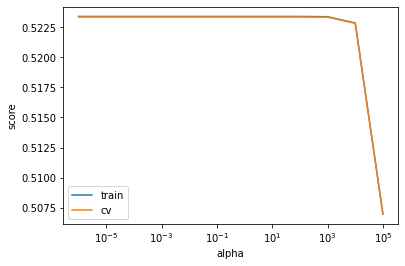

In [161]:
plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [164]:
best_alpha = search.best_params_
best_alpha

{'ridge__alpha': 100.0}

In [162]:
search.best_score_

0.5233469683047616

In [165]:
pipe_bigalpha = make_pipeline(preprocessor, Ridge(alpha=100))
pipe_bigalpha.fit(X_train, y_train)
bigalpha_coeffs = pipe_bigalpha.named_steps["ridge"].coef_
pd.DataFrame(
    data=bigalpha_coeffs, index=new_columns, columns=["Coefficients"]
).sort_values(by="Coefficients", ascending=False)

,Coefficients
Program_ESG,0.227761
Program_Cryptocurrency,0.126559
Requirement_Prep,0.089563
Program_FPWMA,0.066501
Level,0.029076
Program_CRE,0.016992
VideoLenght,0.008136
Price,-0.005960
Requirement_Core,-0.018761
Requirement_Case Study,-0.019828
